# Classification Project 
### Predicting the binary response variable of survival from the Titanic dataset using logisitc regression and naive Bayes



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.naive_bayes import GaussianNB

#FOR UPSAMPLING
from sklearn.utils import resample

In [2]:
titanic_train = pd.read_csv('/Users/kirabreeden/Desktop/Grad_School/Northwestern_MSDS/Sping_2020/MSDS_422/Homeworks/HW_3/train_HW3.csv')
titanic_test = pd.read_csv('/Users/kirabreeden/Desktop/Grad_School/Northwestern_MSDS/Sping_2020/MSDS_422/Homeworks/HW_3/test_HW3.csv')

titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Visualization

Let's start by taking a look at our data and what we are working with. 

Let's see how balanced our classes are...

In [3]:
titanic_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Upsampling...

Okay so they are moderately balanced but let's do some upsampling just to be sure our model behaves as well as possible. We want to avoid our model falsely predicting a classification of value 0 just because we have more instances of our 0 label.  

In [4]:
train_minority = titanic_train[titanic_train.Survived == 1]
train_majority = titanic_train[titanic_train.Survived == 0]

train_minority_upsampled = resample(train_minority, replace=True, n_samples=549, random_state=123) 
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
train_upsampled.Survived.value_counts()

1    549
0    549
Name: Survived, dtype: int64

Now let's check for missing values. 

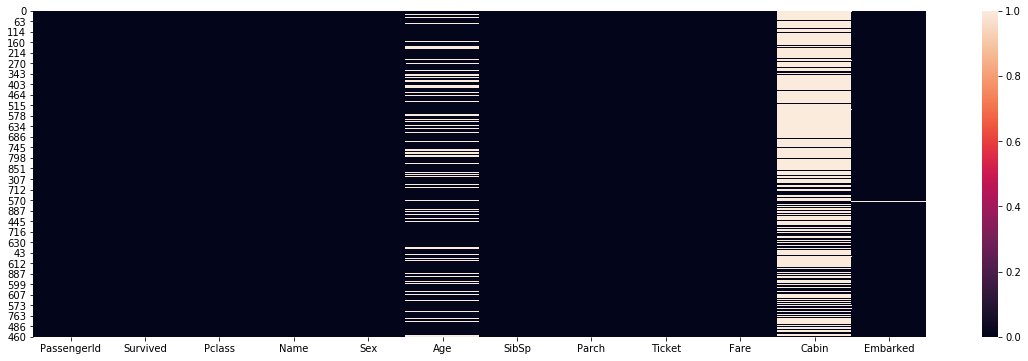

In [5]:
plt.figure(figsize=(20, 6))
sea.heatmap(train_upsampled.isna())

In [6]:
missing = (train_upsampled.isna().sum()/len(train_upsampled)).sort_values(ascending=False)
missing = missing[missing > 0.2]
missing

Cabin    0.734062
dtype: float64

We can see immediately that the cabin variable is pretty incomplete so we will not be using this in our analyses. 

Next let's look at the distribution of our data and look how different variables relate to "Survived"

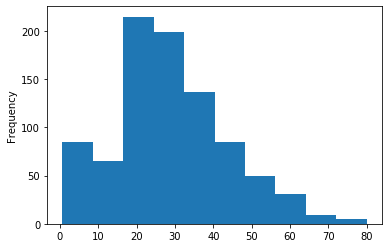

In [7]:
train_upsampled['Age'].plot.hist()

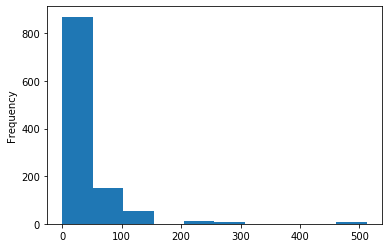

In [8]:
train_upsampled['Fare'].plot.hist()

In [9]:
#Let's bin some of these values 
titanic_train['Ages_binned'] = pd.cut(titanic_train.Age,bins=[0, 10, 20, 30, 40, 50, 60, 70, 100],labels=[0, 1, 2, 3, 4, 5, 6, 7])
titanic_train['Fares_binned'] = pd.cut(titanic_train.Fare,bins=[0, 50, 100, 600],labels=[0, 1, 2])

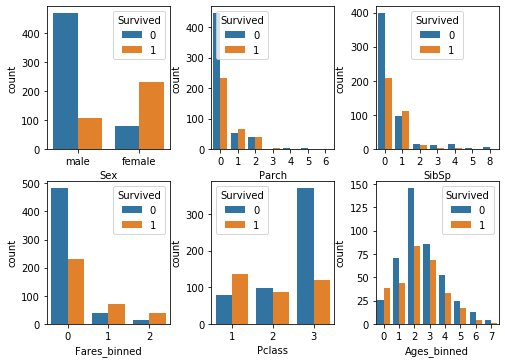

In [10]:
cols = ('Sex', 'Parch', 'SibSp', 'Fares_binned', 'Pclass', 'Ages_binned')
fig, axes = plt.subplots(2, 3, figsize = (7, 5))
fig.tight_layout()
axes = axes.reshape(-1)
# Plot
for i, col in enumerate(cols):
    sea.countplot(x=col, hue = 'Survived', data=titanic_train, ax=axes[i])

Alright so it looks like maybe we've got some things to work from. It seems that the cheaper fares had a higher proportion of people who died as well as men and those with a parch or sibsp value of 0. Also it looks like those under the age of 10 were much more likely to live. 

## Feature Selection/Creation and Remaining Data Cleaning

Lets choose some priliminary variables that we can use to create meaningful, dichotomous, features: 

In [11]:
df_train = train_upsampled[['Sex', 'Age', 'Fare', 'Pclass','SibSp','Parch', 'Survived']]
df_test = titanic_test[['PassengerId', 'Sex', 'Age', 'Fare', 'Pclass', 'SibSp','Parch']]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 645
Data columns (total 7 columns):
Sex         1098 non-null object
Age         881 non-null float64
Fare        1098 non-null float64
Pclass      1098 non-null int64
SibSp       1098 non-null int64
Parch       1098 non-null int64
Survived    1098 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 68.6+ KB


In [12]:
df_train.head()

,Sex,Age,Fare,Pclass,SibSp,Parch,Survived
0,male,22.0,7.2500,3,1,0,0
4,male,35.0,8.0500,3,0,0,0
5,male,NaN,8.4583,3,0,0,0
6,male,54.0,51.8625,1,0,0,0
7,male,2.0,21.0750,3,3,1,0


In [13]:
import warnings

def action_with_warnings():
    warnings.warn("should not appear")

with warnings.catch_warnings(record=True):
    action_with_warnings()

In [14]:
#Let's fill some of these empty values before we create our binary features. 

df_train['Age'].fillna(df_train['Age'].median(), inplace = True)
df_train['Fare'].fillna(df_train['Fare'].median(), inplace = True)

df_test['Age'].fillna(df_test['Age'].median(), inplace = True)
df_test['Fare'].fillna(df_test['Fare'].median(), inplace = True)

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [15]:
#Now let's go ahead and do some feature creation

df_train['Fares_binned'] = pd.cut(df_train.Fare,bins=[-1, 50, 100, 600],labels=[0, 1, 2])
df_test['Fares_binned'] = pd.cut(df_test.Fare,bins=[-1, 50, 100, 600],labels=[0, 1, 2])

sex = {'male': 0, 'female': 1}
df_train['Sex'] = [sex[i] for i in df_train['Sex']]
df_test['Sex'] = [sex[i] for i in df_test['Sex']]

#creating dichotomous features

df_train['Over10'] = pd.cut(df_train.Age,bins=[0,10,100],labels=[0, 1]) #0 is under10, 1 is above10
df_train['ThirdClass'] = pd.cut(df_train.Pclass, bins = [0,2,3], labels = [0,1]) #0 is not third class, 1 is third class
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_train['SibSp0'] = pd.cut(df_train.SibSp, bins = [-1, 0, 10], labels = [1,0]) #1 means 0 sibsp, 0 means other
df_train['Parch0'] = pd.cut(df_train.Parch, bins = [-1, 0, 10], labels = [1,0]) #1 means 0 parch, 0 means other
df_train['LargeFamily'] = pd.cut(df_train.FamilySize, bins = [0,4,20], labels = [0,1]) #0 is under 5 people, 1 if larger
df_train['Elderly'] = pd.cut(df_train.Age, bins=[0,60,1000], labels = [0,1]) #0 if young, 1 if elderly
df_train['Cheap_fare'] = pd.cut(df_train.Fares_binned, bins = [-1, 0, 2], labels = [1, 0]) #1 is cheap, 0 is not


df_test['Over10'] = pd.cut(df_test.Age,bins=[0,10,100],labels=[0, 1]) #0 is under10, 1 is above10
df_test['ThirdClass'] = pd.cut(df_test.Pclass, bins = [0,2,3], labels = [0,1]) #0 is not third class, 1 is third class
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
df_test['SibSp0'] = pd.cut(df_test.SibSp, bins = [-1, 0, 10], labels = [1,0]) #1 means 0 sibsp, 0 means other
df_test['Parch0'] = pd.cut(df_test.Parch, bins = [-1, 0, 10], labels = [1,0]) #1 means 0 parch, 0 means other
df_test['LargeFamily'] = pd.cut(df_test.FamilySize, bins = [0,4,20], labels = [0,1]) #0 is under 5 people, 1 if larger
df_test['Elderly'] = pd.cut(df_test.Age, bins=[0,60,1000], labels = [0,1]) #0 if young, 1 if elderly
df_test['Cheap_fare'] = pd.cut(df_test.Fares_binned, bins = [-1, 0, 2], labels = [1, 0]) #1 is cheap, 0 is not

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to 

In [16]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 645
Data columns (total 16 columns):
Sex             1098 non-null int64
Age             1098 non-null float64
Fare            1098 non-null float64
Pclass          1098 non-null int64
SibSp           1098 non-null int64
Parch           1098 non-null int64
Survived        1098 non-null int64
Fares_binned    1098 non-null category
Over10          1098 non-null category
ThirdClass      1098 non-null category
FamilySize      1098 non-null int64
SibSp0          1098 non-null category
Parch0          1098 non-null category
LargeFamily     1098 non-null category
Elderly         1098 non-null category
Cheap_fare      1098 non-null category
dtypes: category(8), float64(2), int64(6)
memory usage: 86.5 KB


,Sex,Age,Fare,Pclass,SibSp,Parch,Survived,Fares_binned,Over10,ThirdClass,FamilySize,SibSp0,Parch0,LargeFamily,Elderly,Cheap_fare
0,0,22.0,7.2500,3,1,0,0,0,1,1,2,0,1,0,0,1
4,0,35.0,8.0500,3,0,0,0,0,1,1,1,1,1,0,0,1
5,0,27.0,8.4583,3,0,0,0,0,1,1,1,1,1,0,0,1
6,0,54.0,51.8625,1,0,0,0,1,1,0,1,1,1,0,0,0
7,0,2.0,21.0750,3,3,1,0,0,0,1,5,0,0,1,0,1


In [17]:
df_use = df_train[['Sex', 'Over10', 'ThirdClass', 'Cheap_fare', 'SibSp0', 'Parch0', 'Survived']]
df_use_predict = df_test[['PassengerId','Sex', 'Over10', 'ThirdClass', 'Cheap_fare', 'SibSp0', 'Parch0']]

In [18]:
df_use.head()

,Sex,Over10,ThirdClass,Cheap_fare,SibSp0,Parch0,Survived
0,0,1,1,1,0,1,0
4,0,1,1,1,1,1,0
5,0,1,1,1,1,1,0
6,0,1,0,0,1,1,0
7,0,0,1,1,0,0,0


Alright so now we have our training set that we will use in our models where all features are binary and (hopefully) meaningful. 

In [19]:
#Here we will separate our x and our y values (features and labels)
X = np.array(df_use.drop(['Survived'], 1))
y = np.array(df_use['Survived'])

#we will let our validation set for cross_validation be 20% of our training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_predict = np.array(df_use_predict.drop(['PassengerId'], 1))

## Logistic regression 

 Use cross-validation on the training set prior to submitting your forecasts to be graded on the Kaggle.com
        withheld test set. Evaluate these methods within a cross-validation design as well as on the test set
        (minimum of two Kaggle.com submissions).



In [20]:
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
test_predictions_logreg = log_reg.predict(X_test)
test_predictions_logreg

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1])

Starting with taking a look at accuracy...

In [22]:
accuracy_LogReg = accuracy_score(y_test, test_predictions_logreg)
accuracy_LogReg

0.7545454545454545

But of course, accuracy can be pretty skewed in classification so we will also go ahead and evaluate the ROC AUC. 

In [23]:
predictions_logreg = log_reg.predict(X_predict)
predictions_Id = np.array(df_use_predict['PassengerId'])
log_reg_sub = np.column_stack((predictions_Id, predictions_logreg))
#np.savetxt('Breeden_Titanic_Sub9.csv', log_reg_sub, delimiter=',', fmt='%d')

In [24]:
y_scores_train = cross_val_predict(log_reg, X_train, y_train, cv=3, method="decision_function")
y_scores_test = cross_val_predict(log_reg, X_test, y_test, cv=3, method="decision_function")

In [25]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_train)

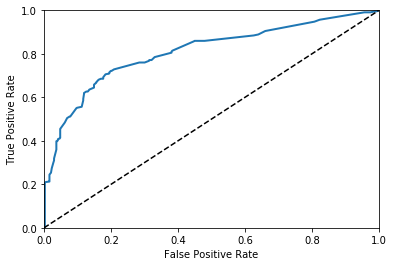

In [26]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr) 
plt.show()

In [27]:
print('ROC AUC score train: ', roc_auc_score(y_train, y_scores_train))
print('ROC AUC score test: ', roc_auc_score(y_test, y_scores_test))

ROC AUC score train:  0.8088442857735896
ROC AUC score test:  0.8271441568108511


## Naïve Bayes classification

 Use cross-validation on the training set prior to submitting your forecasts to be graded on the Kaggle.com
        withheld test set. Evaluate these methods within a cross-validation design as well as on the test set
        (minimum of two Kaggle.com submissions).




In [28]:
Bayes = GaussianNB()
Bayes.fit(X_train, y_train)
test_predictions_Bayes = Bayes.predict(X_test)
test_predictions_Bayes

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

Let's check our preliminary accuracy...

In [29]:
accuracy_Bayes = accuracy_score(y_test, test_predictions_Bayes)*100
accuracy_Bayes

75.0

But then of course let's check our ROC AUC for a more representative evaluation of performance. 

In [30]:
predictions_Bayes = Bayes.predict(X_predict)
bayes_sub = np.column_stack((predictions_Id, predictions_Bayes))
#np.savetxt('Breeden_Titanic_Sub7.csv', bayes_sub, delimiter=',', fmt='%d')

In [31]:
y_scores_train = cross_val_predict(Bayes, X_train, y_train, cv=3, method="predict_proba")
y_scores_test = cross_val_predict(Bayes, X_test, y_test, cv=3, method="predict_proba")

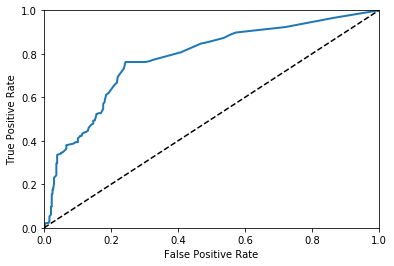

In [32]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_train[:,1])
plot_roc_curve(fpr, tpr) 
plt.show()

In [33]:
print('ROC AUC score train: ', roc_auc_score(y_train, y_scores_train[:,1]))
print('ROC AUC score test: ', roc_auc_score(y_test, y_scores_test[:,1]))

ROC AUC score train:  0.7794013865249699
ROC AUC score test:  0.7938962864940865


## Management Problem

Let's imagine that we are providing evidence regarding characteristics associated with survival on this ill-fated voyage to a historian writing a book.  Which of the two modeling methods should we recommend and why?

I would recommend logistic regression because naive bayes depends so much on assumptions and just does not perform as well. Even when the assumptions of independence are met for naive bayes, it only performs as well as logistic regression. Because often assumptions of independence are not possible and we can definitely not make those assumptions for this dataset (Pclass is obviously related to ticket fare etc), I would not choose naive bayes as the optimal modeling method. 

As we can see from the models I have outlined above, we have a better performance measure from the ROC AUC for the logistic regression than we do from the naive bayes. For this reason I would recommend using logistic regression in order to determine characteristics associated with survival for this tragic accident. 